In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

In [3]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Some Classification

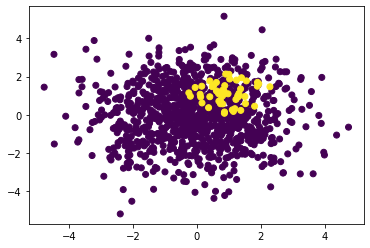

In [110]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [1.0, 1.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

In [111]:
input_size = 2
hidden_size = 12
output_size = 2

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [112]:
epochs = 10000
learning_rate = 0.01

In [99]:
class CVaRLoss(nn.Module):
    def __init__(self, a=0.05, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.criterion = criterion
        self.reduction = reduction
    
    def _value_at_risk(self, loss):
        sorted_loss, sorted_indices = torch.sort(loss, dim=0, descending=False, stable=True)
        empirical_cdf = torch.argsort(sorted_indices) / len(loss)
        sorted_cdf, _ = torch.sort(empirical_cdf, dim=0, descending=False, stable=True)
        value_at_risk_idx = np.searchsorted(sorted_cdf, 1 - self.a, side='left')
        return sorted_loss[value_at_risk_idx]
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        values_at_risk = (loss >= self._value_at_risk(loss)).nonzero().squeeze()
        
        if self.reduction == 'mean':
            return torch.mean(torch.index_select(loss, 0, values_at_risk))
        elif self.reduction == 'sum':
            return torch.sum(torch.index_select(loss, 0, values_at_risk))
        return values_at_risk

1.009911298751831
0.7017608880996704
0.6949760913848877
0.6998993158340454
0.7005258798599243
0.6934856176376343
0.7033402323722839
0.6950852274894714
0.6978763937950134
0.6945272088050842
Final loss:  0.695848822593689


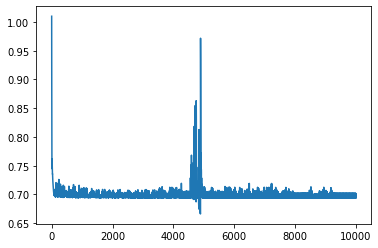

In [106]:
criterion = CVaRLoss(a=0.05)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

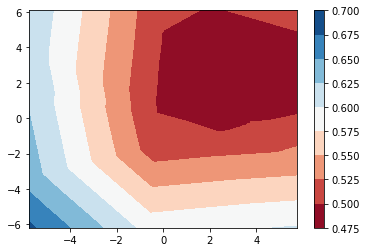

In [107]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

## Trimmed Risk

In [145]:
class TrimmedRisk(nn.Module):
    def __init__(self, a=0.05, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.criterion = criterion
        self.reduction = reduction
    
    def _get_untrimmed_losses(self, loss):
        sorted_indices = torch.argsort(loss, dim=0, descending=False)
        empirical_cdf = torch.argsort(sorted_indices) / len(loss)
        return ((empirical_cdf >= self.a) & (empirical_cdf <= 1 - self.a)).nonzero().squeeze()
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        untrimmed_losses = self._get_untrimmed_losses(loss)
        
        if self.reduction == 'mean':
            return torch.mean(torch.index_select(loss, 0, untrimmed_losses))
        elif self.reduction == 'sum':
            return torch.sum(torch.index_select(loss, 0, untrimmed_losses))
        return torch.index_select(loss, 0, untrimmed_losses)

0.5134333372116089
0.0007737104897387326
0.0003480282030068338
0.00021785448188893497
0.00015626722597517073
0.00012075761333107948
9.784325084183365e-05
8.192800305550918e-05
7.026557432254776e-05
6.137690070318058e-05
Final loss:  5.440007953438908e-05


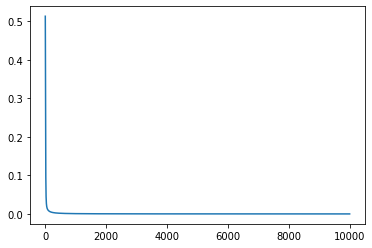

In [157]:
criterion = TrimmedRisk(a=0.05)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

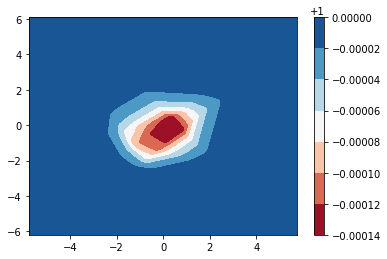

In [158]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

## Mean-variance

In [161]:
class MeanVariance(nn.Module):
    def __init__(self, c=0, criterion=nn.CrossEntropyLoss(reduction='none')):
        super().__init__()
        self.c = c
        self.criterion = criterion
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        var, mean = torch.var_mean(loss, unbiased=False)
        
        return mean + torch.mul(var, self.c)

0.9448999166488647
0.4562529921531677
0.4534391164779663
0.4526609480381012
0.45194435119628906
0.4497838020324707
0.4490240812301636
0.44822990894317627
0.4472618103027344
0.44643980264663696
Final loss:  0.44582223892211914


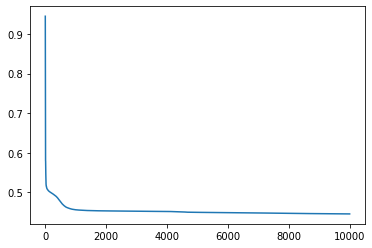

In [170]:
criterion = MeanVariance(c=5)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

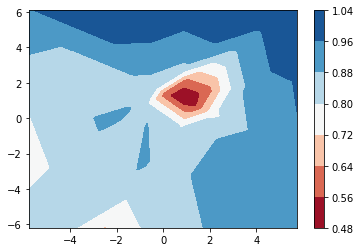

In [171]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)